# Final Project
## Network Science HS19
### Imports

In [2]:
import geopandas as gpd
import fiona
import networkx as nx
import matplotlib.pyplot as plt
import random

### Load the data

In [4]:
#create a list of layers with in a file geodatabase 
layerlist = fiona.listlayers('./Schienennetz_LV03_20171210.gdb')
#print(layerlist)
netzknoten = gpd.read_file('./Schienennetz_LV03_20171210.gdb',layer='Netzknoten')
#display(netzknoten.head())
netzsegment = gpd.read_file('./Schienennetz_LV03_20171210.gdb',layer='Netzsegment')
#display(netzsegment.head())


### Create the network graph

In [5]:
#The nodes have their name and geometry(location) associated
G = nx.Graph()
for index, row in netzknoten.iterrows():
    G.add_node(row.xtf_id, geometry = row.geometry, name = row.Betriebspunkt_Name)
    
for index, row in netzsegment.iterrows():
    G.add_edge(row.rAnfangsknoten, row.rEndknoten)


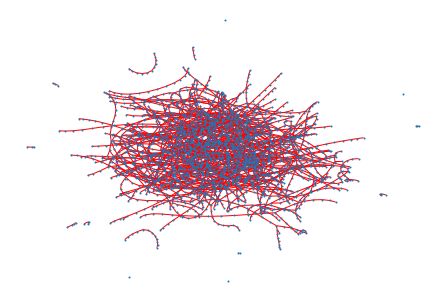

In [18]:
nx.draw(G, node_size=1, edge_color="r", with_labels = False, labels = nx.get_node_attributes(G, "name"),figsize=(10, 10))
geometries = nx.get_node_attributes(G, "geometry")


#drawing with positional data
for key in geometries:
    geometries[key] = [float(geometries[key].x),float(geometries[key].y)]
#nx.draw_networkx(G,pos = geometries ,with_labels= False, node_size = 2, edge_color = "r", labels = nx.get_node_attributes(G, "name"))

### Draw the network on the map of Switzerland

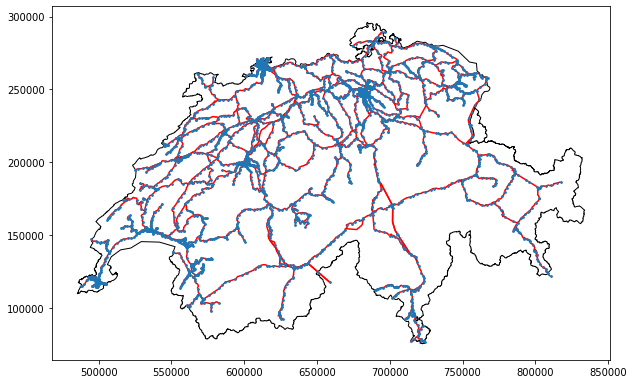

In [23]:
# Load map
map = gpd.read_file('./Maps/swissBOUNDARIES3D_1_3_TLM_LANDESGEBIET.shx')

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

map.plot(ax=ax, color='w', edgecolor='black', zorder=0)
netzsegment.plot(ax=ax, color='r', zorder=100)
netzknoten.plot(ax=ax, marker='o', markersize=3, zorder=200)

plt.show()

## Analysis
### Calculate Degree distribution

In [8]:
#Some figures for the network: average degree <k>, global clustering coefficient C, assortativity etc.
degree_sequence = [d for n, d in G.degree()]

average_degree = sum(degree_sequence)/len(degree_sequence)
print("average degree ⟨k⟩ =",average_degree)

C = sum(nx.clustering(G).values())/len(nx.clustering(G).values())
print("global clustering C=", C)

assortativity = nx.degree_assortativity_coefficient(G)
print("assortativity=",assortativity)

print("number of connected components= ", nx.number_connected_components(G))

largest_cc = max(nx.connected_components(G), key=len)
number_largest_cc = len(largest_cc) 
number_nodes = len(G.nodes())
print("Relative size of the giant component to the full network =", number_largest_cc/number_nodes)


average degree ⟨k⟩ = 2.102194357366771
global clustering C= 0.015946161118574925
assortativity= 0.19889027126014727
number of connected components=  47
Relative size of the giant component to the full network = 0.5250783699059561


[4, 235, 2490, 378, 67, 11, 3, 1, 0, 1]


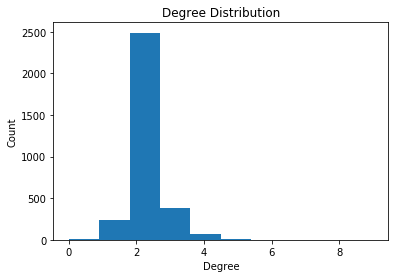

In [9]:
#Degree Distribution of the network
hist = nx.degree_histogram(G)
print(hist)
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.hist(degree_sequence, bins = len(hist))
                     
plt.show()

In [10]:
#Centralities  (Do we need the correlations between them??)
degree = sorted(list(nx.degree_centrality(G).values()), reverse =True)
closeness = sorted(list(nx.closeness_centrality(G).values()), reverse =True)
betweenness = sorted(list(nx.betweenness_centrality(G).values()), reverse =True)
eigenvector = sorted(list(nx.eigenvector_centrality(G).values()), reverse =True)

print(max(degree))
print(max(closeness))
print(max(betweenness))
print(max(eigenvector))

0.002822201317027281
0.013534777445549909
0.11844650721988634
0.48696013737582694


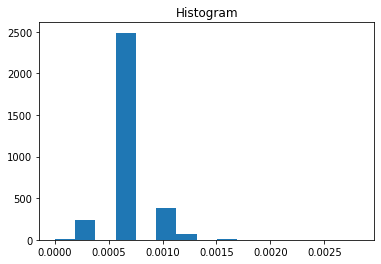

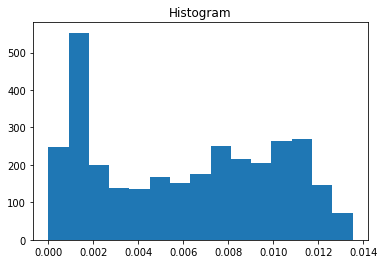

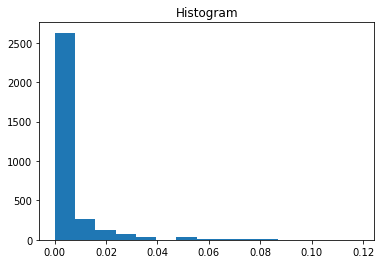

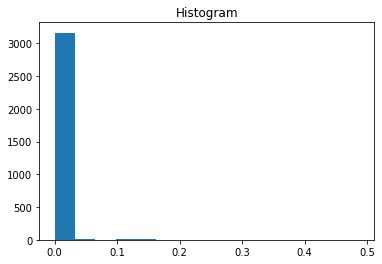

In [11]:
# Distribution of the centralities
def histogram(data, bins):
    plt.title("Histogram")
    plt.hist(data,bins=bins)
    plt.show()

histogram(degree,15)
histogram(closeness,15)
histogram(betweenness,15)
histogram(eigenvector, 15)

### Simulate random and targeted attacks

In [12]:
def random_attacks(G):
    temp = G.copy()
    connected_component_sizes = []
    while nx.number_of_nodes(temp) > 1:
        node_list = temp.nodes()
        to_delete = random.choice(list(node_list))
        temp.remove_node(to_delete)
        
        largest_cc = len(max(nx.connected_components(temp), key=len))
        connected_component_sizes.append(largest_cc)
    
    plt.plot(range(len(connected_component_sizes)),connected_component_sizes)
    plt.title("Random attacks")
    plt.ylabel("Size of Giant component")
    plt.xlabel("Number of removed Nodes")
    plt.show()
    
def targeted_attacks(G):
    temp = G.copy()
    connected_component_sizes = []
    node_degrees = nx.degree_centrality(temp)
    sorted_node_degrees = sorted(temp.nodes(), key=lambda n: node_degrees[n])
    while nx.number_of_nodes(temp) > 1:
        temp.remove_node(sorted_node_degrees.pop())
        largest_cc = len(max(nx.connected_components(temp), key=len))
        connected_component_sizes.append(largest_cc)
    
    plt.plot(range(len(connected_component_sizes)),connected_component_sizes)
    plt.title("Targeted attacks")
    plt.ylabel("Size of Giant component")
    plt.xlabel("Number of removed Nodes")
    plt.show()

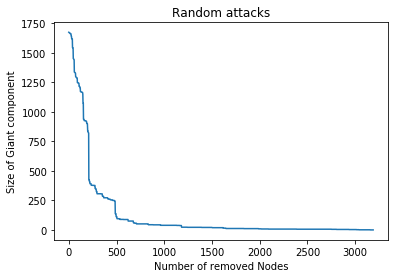

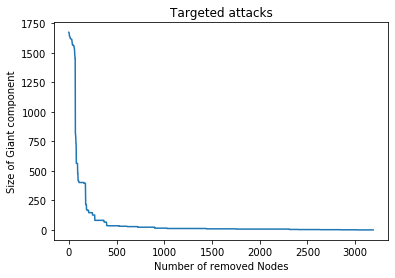

In [13]:
#Incluence of Random or targeted attacks on the remaining size of the Giant component
random_attacks(G)
targeted_attacks(G)